In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data

In [23]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/"
    "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
    index_col=0,
    parse_dates=True,
)

In [24]:
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Axes: xlabel='Month'>

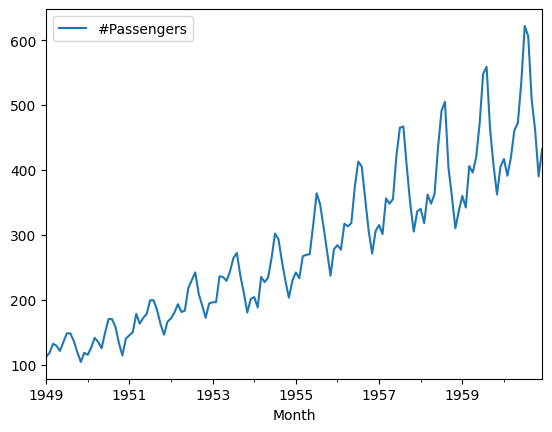

In [25]:
df.plot()

#### Plot a single year

<Axes: xlabel='Month'>

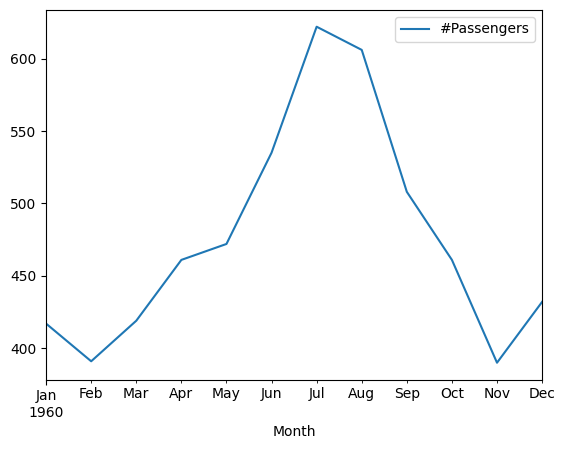

In [26]:
df.loc["1960"].plot()

### Plot the seasonality

<Axes: xlabel='Month'>

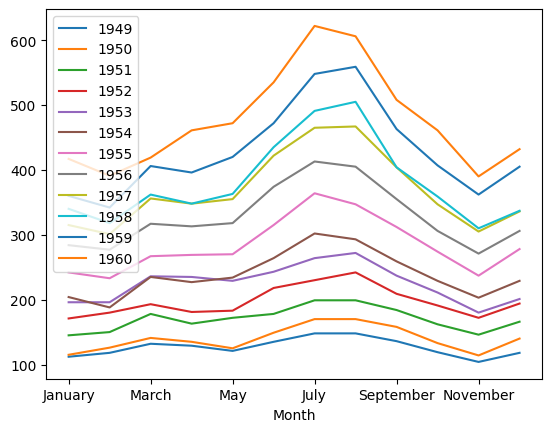

In [27]:
df_seasonality = pd.DataFrame(index=df.index.month_name().unique())

for year in df.index.year.unique():
    df_seasonality[f"{year}"] = df.loc[f"{year}"].values

df_seasonality.plot()

<Axes: xlabel='Month'>

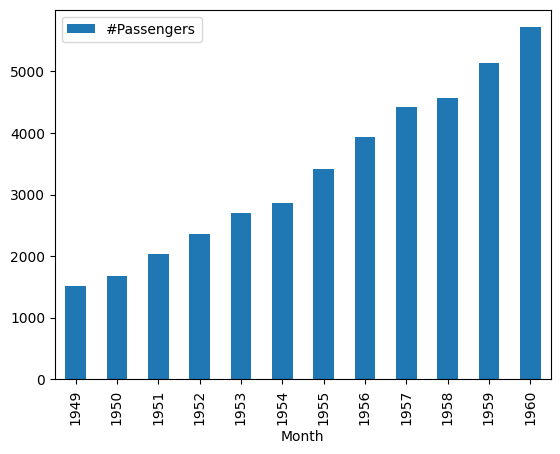

In [28]:
df.groupby(df.index.year).sum().plot(kind="bar")

Clearly we have an upward trend. #Passengers is growing every year.

To visualize the seasonality clearer we should remove the trend. 
For this a transformation like percentage change or log is possible.

<Axes: xlabel='Month'>

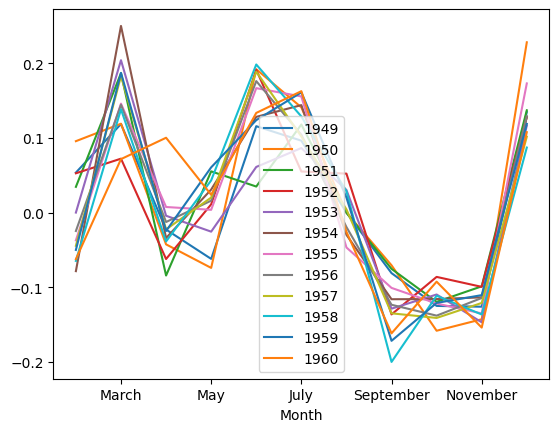

In [29]:
df_seasonality = pd.DataFrame(index=df.index.month_name().unique())

for year in df.index.year.unique():
    df_seasonality[f"{year}"] = df.loc[f"{year}"].pct_change().values

df_seasonality.plot()

# Convert the time series to stationary

Most models benifit from having constant mean and variance in the data, for others its an important requirement.

## Let´s test stationarity

This code snippets are from the statsmodels web examples
https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [32]:
adf_test(df)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [33]:
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)



In [34]:
kpss_test(df)

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/workspaces/training-code/task_forecasting_training/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Let´s try taking the difference

<Axes: xlabel='Month'>

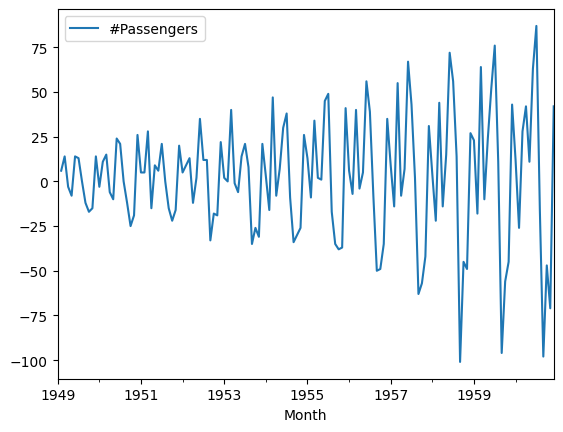

In [35]:
df.diff().plot()

<Axes: xlabel='Month'>

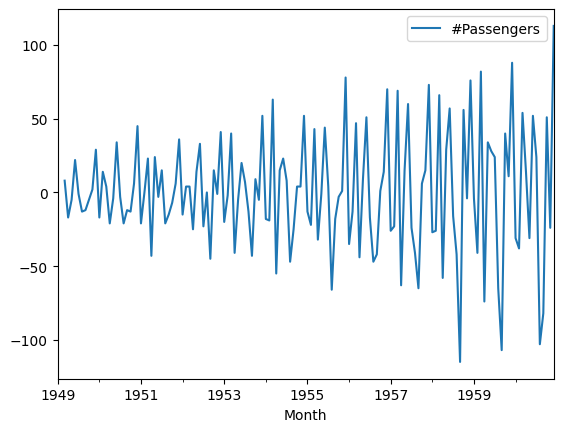

In [36]:
df.diff().diff().plot()

In [37]:
kpss_test(df.diff().dropna())

Results of KPSS Test:
Test Statistic           0.023898
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/workspaces/training-code/task_forecasting_training/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## We need remove the trend to make it stationary

<Axes: xlabel='Month'>

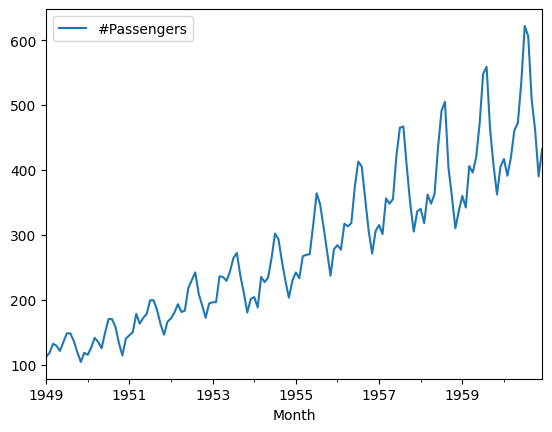

In [38]:
df.plot()

### Use a log transformation and de-trend using a rolling mean

In [39]:
df_stationary = np.log(df) - np.log(df).rolling(12).mean()
df_stationary.dropna(inplace=True)

<Axes: xlabel='Month'>

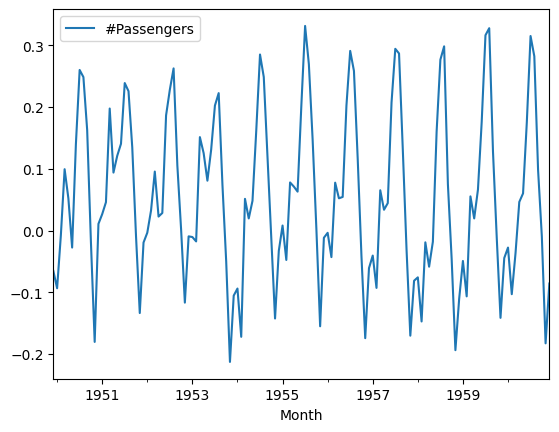

In [40]:
df_stationary.plot()

In [41]:
adf_test(df_stationary)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [42]:
kpss_test(df_stationary)

Results of KPSS Test:
Test Statistic           0.04306
p-value                  0.10000
Lags Used                5.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


/workspaces/training-code/task_forecasting_training/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### There is also packages for detrending

In [43]:
from statsmodels.tsa.tsatools import detrend

<Axes: xlabel='Month'>

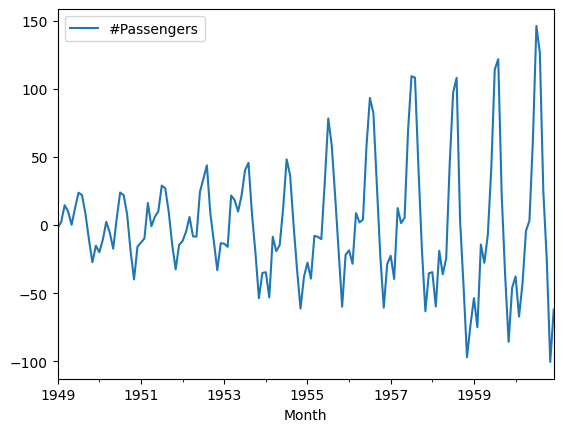

In [44]:
detrend(
    df, 
    order=2
).plot()

<Axes: xlabel='Month'>

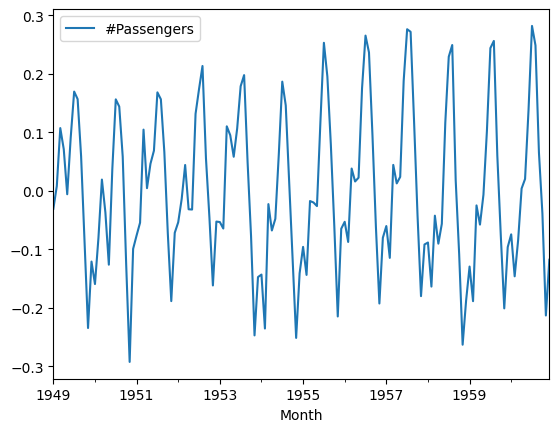

In [45]:
detrend(
    np.log(df), 
    order=2
).plot()

#### Transforming with percentage change can also make the timeseries stationary

<Axes: xlabel='Month'>

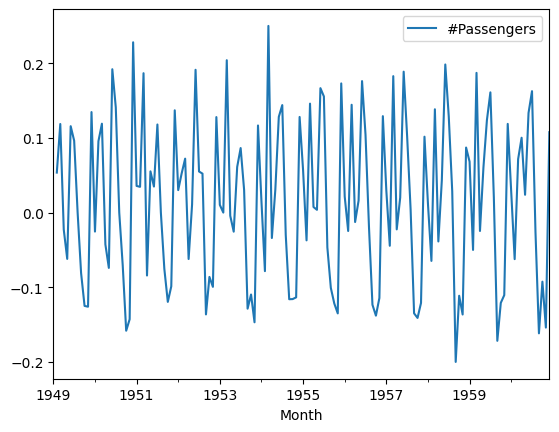

In [46]:
df.pct_change().plot()

In [47]:
### Which is a very similar calculation to taking the log differene

<Axes: xlabel='Month'>

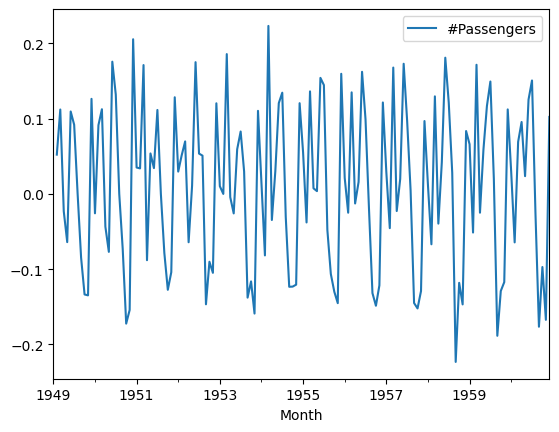

In [48]:
np.log(df).diff().plot()

There is also the seasonal decompose in statsmodels

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [50]:
analysis = seasonal_decompose(df, model="multiplicative", period=12)

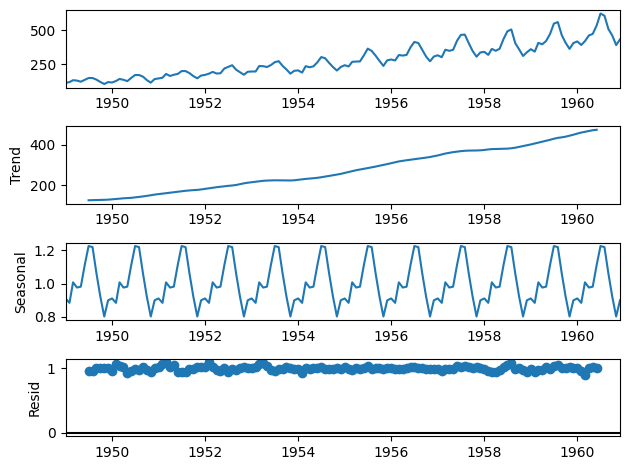

In [51]:
analysis.plot()
plt.show()

In [52]:
analysis.trend.dropna()

Month
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
1949-11-01    129.000000
                 ...    
1960-02-01    461.375000
1960-03-01    465.208333
1960-04-01    469.333333
1960-05-01    472.750000
1960-06-01    475.041667
Name: trend, Length: 132, dtype: float64

### Let´s look at the autocorrelation and partial autocorrelation

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

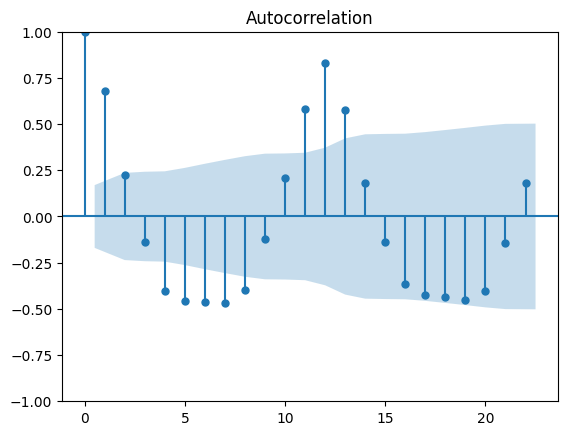

In [54]:
plot_acf(df_stationary).show()

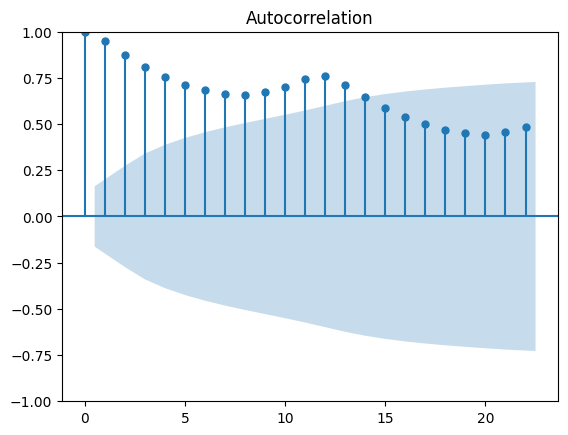

In [55]:
plot_acf(df).show()

/workspaces/training-code/task_forecasting_training/.venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


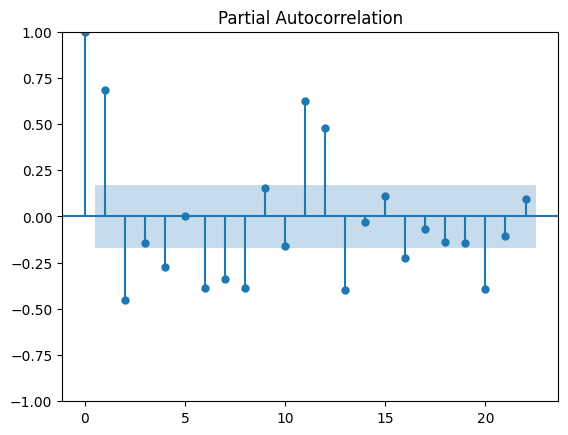

In [57]:
plot_pacf(df_stationary).show()

/workspaces/training-code/task_forecasting_training/.venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


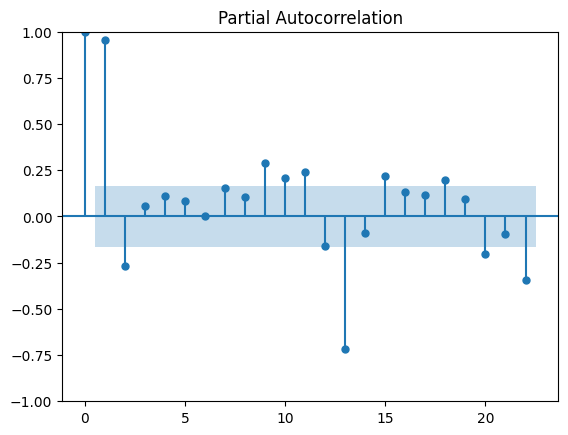

In [56]:
plot_pacf(df).show()